# Notebook 1 
## Sleep Detection - EDA
In this notebook we:
- load the project data from <b>"sleep_data_120_series.csv"</b> file,
- explore the data to see if values are as expected from the description,
- check if we have missing values,
- calculate new feature - "hour",
- calculate correlations and save highly correlated features into a file -> <b>"features_to_exclude.txt"</b>,
- explore the relation of features with target variable.

In [1]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

pl.Config.set_fmt_str_lengths(100)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from helpers import create_rolling_features, concat_in_order

## Loading data
- Data is quite large so we use <b>Polars</b> instead of </b>Pandas</b> for major transformations.

In [2]:
train_data_file = 'child-mind-institute-detect-sleep-states/sleep_data_120_series.csv'

In [3]:
df = pl.read_csv(train_data_file, dtypes={
    "dt_minute":pl.Datetime
})

In [4]:
df.head()

series_id,step,dt_minute,anglez,enmo,target
str,i64,datetime[μs],i64,i64,i64
"""05e1944c3818""",0,2018-11-16 18:00:00,-86,15,0
"""05e1944c3818""",12,2018-11-16 18:01:00,-86,15,0
"""05e1944c3818""",24,2018-11-16 18:02:00,-86,19,0
"""05e1944c3818""",36,2018-11-16 18:03:00,-86,14,0
"""05e1944c3818""",48,2018-11-16 18:04:00,-86,14,0


#### Do we have any NULLs or NaNs?
- No missing data - after running the checks below we see that our data is complete.

##### Any NaN's?

In [5]:
df.drop(["series_id","dt_minute","step_min","night_id","night_start_date"]).select(pl.all().is_nan().sum()).transpose(
    include_header=True, header_name="feature",column_names=["nan's"]).filter(pl.col("nan's")>0)

feature,nan's
str,u32


##### Any NULL's?

In [6]:
df.drop(["series_id","dt_minute","step_min","night_id","night_start_date"]).select(pl.all().is_null().sum()).transpose(
    include_header=True, header_name="feature",column_names=["null's"]).filter(pl.col("null's")>0)

feature,null's
str,u32


#### Do we have 120 series_id's?
- Yes, we do.

In [7]:
df["series_id"].unique().shape

(120,)

### Datetime feature - hour
- Datetime can't be our feature but we can extract hour from it.
- Also on the bar plot below we see that there are hours when sleep occurs with much higher probability (3 or 4 o'clock) that for others (13 or 14 o'clock).

In [8]:
df = df.with_columns(
    pl.col('dt_minute').dt.hour().cast(pl.UInt8).alias('hour')
)

In [9]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour
str,i64,datetime[μs],i64,i64,i64,u8
"""05e1944c3818""",0,2018-11-16 18:00:00,-86,15,0,18
"""05e1944c3818""",12,2018-11-16 18:01:00,-86,15,0,18
"""05e1944c3818""",24,2018-11-16 18:02:00,-86,19,0,18
"""05e1944c3818""",36,2018-11-16 18:03:00,-86,14,0,18
"""05e1944c3818""",48,2018-11-16 18:04:00,-86,14,0,18


In [10]:
print("Total observations per hour during the day")
df.group_by("hour").agg(pl.col("target").count().alias("observations per hour")).sort(by="hour")

Total observations per hour during the day


hour,observations per hour
u8,u32
0,21540
1,21540
2,21420
3,21540
4,21540
5,21540
6,21540
7,21540
8,21540


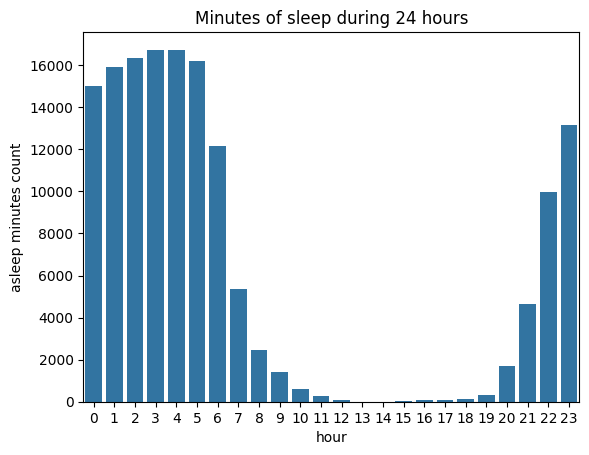

In [11]:
sns.barplot(data=df.group_by("hour").agg((pl.col("target")==1).sum().alias("asleep minutes count")).sort(by="hour"),x="hour",y="asleep minutes count");
plt.title('Minutes of sleep during 24 hours');

Summary
- <b>"Hour"</b> can be an important feature in modelling the sleep time.

### Basic statistics of features
- There are only numeric features.

In [12]:
features = ["anglez", "enmo", "hour"]

In [13]:
labels = "target"

In [14]:
df.select(features + [labels]).describe()

describe,anglez,enmo,hour,target
str,f64,f64,f64,f64
"""count""",517109.0,517109.0,517109.0,517109.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",-10.11836,42.926859,11.50279,0.422625
"""std""",35.401218,78.13508,6.919568,0.614582
"""min""",-90.0,0.0,0.0,0.0
"""25%""",-33.0,3.0,6.0,0.0
"""50%""",-11.0,21.0,12.0,0.0
"""75%""",9.0,48.0,17.0,1.0
"""max""",90.0,2620.0,23.0,2.0


#### Features correlation
- Below we can see that all "enmo" features are 

In [15]:
features_correlations = (
    df.select(features + [labels]).corr()
    .with_columns(index = pl.Series(df.select(features + [labels]).columns))
    .melt(id_vars = "index")
    .filter(pl.col('index') != pl.col('variable'))
)

In [16]:
features_correlations.with_columns(pl.col("value").round(5)).sort(pl.col("value").abs(), descending=True).unique(subset="value")

index,variable,value
str,str,f64
"""hour""","""anglez""",-0.0155
"""target""","""anglez""",0.00877
"""target""","""hour""",-0.29727
"""target""","""enmo""",-0.20802
"""enmo""","""anglez""",-0.00012
"""hour""","""enmo""",0.15549


- Our features are not correlated with each other - which is good.
- Features are not correlated with the target neaither. It may be because the relation is not linear (like with "hour") <br>or/and we may need to create new features - rolling features describing longer time periods than just one minute. 

#### When did the observations happen?
- Between 2017-08-11 and 2019-05-31.

In [17]:
df.group_by("series_id").agg(
    pl.col("dt_minute").min().alias("start"),
    pl.col("dt_minute").max().alias("end")
).sort(by="start")

series_id,start,end
str,datetime[μs],datetime[μs]
"""e34b496b84ce""",2017-08-11 13:15:00,2017-08-14 13:15:00
"""f6d2cc003183""",2017-08-14 12:30:00,2017-08-17 12:30:00
"""def21f50dd3c""",2017-08-15 13:45:00,2017-08-18 13:45:00
"""0ce74d6d2106""",2017-08-21 16:30:00,2017-08-24 16:30:00
"""2fbbee1a38e3""",2017-08-31 12:30:00,2017-09-03 12:30:00
"""c7d693f24684""",2017-08-31 13:30:00,2017-09-03 13:30:00
"""51b23d177971""",2017-09-06 12:15:00,2017-09-09 12:15:00
"""5f94bb3e1bed""",2017-09-08 16:15:00,2017-09-11 16:15:00
"""e6ddbaaf0639""",2017-09-27 13:15:00,2017-09-30 13:15:00


### Target variable
- Our dataset is imbalanced.
- We need to check if the labels==2 will be there in all train, validation and test sets.
- We can check is adding weights in the model definition help improve the results.

In [18]:
df_labels = df.group_by(labels).agg(
    pl.col("dt_minute").count().alias("count")
)
df_labels.with_columns(frac = (pl.col("count") / df_labels["count"].sum()).round(2))

target,count,frac
i64,u32,f64
0,333134,0.64
1,149407,0.29
2,34568,0.07


## Rolling features
- Our feaures ("anglez" and "enmo") are one minute averages. However, we see on the time plot that longer periods determine sleep state better.
- We will create more features for longer periods rolling windows.

In [19]:
df = create_rolling_features(df)

In [20]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diffs_15m_sum,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diffs_15m_sum,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diffs_60m_sum,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diffs_60m_sum,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diffs_180m_sum,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diffs_180m_sum,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diffs_480m_sum,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diffs_480m_sum,enmo_diffs_sum_div_max_min_15m,anglez_diffs_sum_div_max_min_15m,enmo_diffs_sum_div_max_min_60m,anglez_diffs_sum_div_max_min_60m,enmo_diffs_sum_div_max_min_180m,anglez_diffs_sum_div_max_min_180m,enmo_diffs_sum_div_max_min_480m,anglez_diffs_sum_div_max_min_480m
str,i64,datetime[μs],i64,i64,i64,u8,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""05e1944c3818""",0,2018-11-16 18:00:00,-86,15,0,18,15.0,19,14,1.690309,2.070197,-86.0,-86,-86,0.0,0.0,14.366667,19,13,1.217214,1.465532,-86.0,-83,-87,0.909718,0.775232,61.066667,425,6,83.150709,52.238771,-38.111111,17,-87,41.805178,8.793642,73.141667,425,0,81.16833,51.104065,-22.241667,63,-87,31.913585,12.243604,0.345033,0.0,0.209362,0.155046,0.124378,0.083749,0.119963,0.081083
"""05e1944c3818""",12,2018-11-16 18:01:00,-86,15,0,18,14.888889,19,14,1.615893,1.995531,-86.0,-86,-86,0.0,0.0,14.354839,19,13,1.198565,1.440386,-86.032258,-83,-87,0.912282,0.76489,61.637363,425,6,82.866495,52.443828,-37.857143,17,-87,41.642812,8.852664,73.024896,425,0,81.019335,51.057749,-22.153527,63,-87,31.87641,12.238203,0.332588,0.0,0.205769,0.152978,0.124866,0.084311,0.119854,0.081048
"""05e1944c3818""",24,2018-11-16 18:02:00,-86,19,0,18,14.8,19,14,1.549193,1.922094,-86.0,-86,-86,0.0,0.0,14.34375,19,13,1.180743,1.424064,-86.0625,-83,-87,0.913607,0.754912,61.26087,425,6,82.48901,52.43287,-37.543478,17,-87,41.522512,8.803346,72.842975,425,0,80.900585,50.973559,-22.041322,63,-87,31.858061,12.2156,0.320349,0.0,0.203438,0.150982,0.12484,0.083841,0.119656,0.080898
"""05e1944c3818""",36,2018-11-16 18:03:00,-86,14,0,18,14.727273,19,14,1.489356,1.852926,-86.0,-86,-86,0.0,0.0,14.333333,19,13,1.163687,1.408142,-86.090909,-83,-87,0.913908,0.745281,60.978495,425,6,82.084657,52.218984,-37.247312,17,-87,41.394879,8.770553,73.078189,425,0,80.816482,51.022072,-22.012346,63,-87,31.795379,12.206735,0.308821,0.0,0.201163,0.149056,0.124331,0.083529,0.11977,0.080839
"""05e1944c3818""",48,2018-11-16 18:04:00,-86,14,0,18,14.666667,19,14,1.435481,1.788854,-86.0,-86,-86,0.0,0.0,14.352941,19,13,1.151609,1.386488,-86.117647,-83,-87,0.913359,0.73598,60.425532,425,6,81.817984,51.941965,-36.851064,17,-87,41.350575,8.73272,73.032787,425,0,80.65314,50.949226,-21.836066,63,-87,31.849146,12.293673,0.298142,0.0,0.19807,0.147196,0.123671,0.083169,0.119599,0.081415


### Correlations

In [30]:
df_numeric = df.drop([
    "series_id",
    "dt_minute",
    "step"
])

features_correlations = (
    df_numeric.corr()
    .with_columns(index = pl.Series(df.select(df_numeric.columns).columns))
    .melt(id_vars = "index")
    .filter(pl.col('index') != pl.col('variable'))
)

features_correlations = features_correlations.with_columns([
    pl.struct(["index", "variable"]).map_elements(concat_in_order).alias("vars_pair")
]).unique(subset=["vars_pair"]).sort(pl.col("value").abs(), descending=True).select("index","variable","value")

In [33]:
features_correlations.with_columns(pl.col("value").round(2)).head(25)

index,variable,value
str,str,f64
"""enmo_15m_std""","""enmo_15m_max""",0.98
"""enmo_diffs_60m_sum""","""enmo_60m_max""",0.97
"""enmo_diffs_180m_sum""","""enmo_180m_max""",0.97
"""enmo_60m_std""","""enmo_60m_max""",0.96
"""enmo_diffs_15m_sum""","""enmo_15m_max""",0.95
"""enmo_diffs_180m_sum""","""enmo_180m_std""",0.95
"""enmo_diffs_480m_sum""","""enmo_480m_std""",0.95
"""enmo_diffs_15m_sum""","""enmo_15m_std""",0.95
"""enmo_diffs_60m_sum""","""enmo_60m_std""",0.95


We don't need both features from highly correlated features pair.

In [34]:
correlated_features = [
    "enmo_15m_max","enmo_60m_max","enmo_180m_max","enmo_480m_max",
    "enmo_diffs_15m_sum","enmo_diffs_60m_sum","enmo_diffs_180m_sum","enmo_diffs_480m_sum",
    "anglez","anglez_15m_mean","anglez_15m_std",
    "enmo_15m_mean","enmo_60m_mean","enmo_60m_mean","enmo_180m_mean","enmo_480m_mean"
]

In [36]:
with open(r'features_to_exclude.txt', 'w') as fp:
    fp.write('\n'.join(correlated_features))

In [35]:
features_correlations.filter(~(pl.col("index").is_in(correlated_features)|pl.col("variable").is_in(correlated_features))) \
    .with_columns(pl.col("value").round(6)).sort(pl.col("value").abs(), descending=True).head(15)

index,variable,value
str,str,f64
"""anglez_diffs_480m_sum""","""anglez_diffs_180m_sum""",0.842927
"""anglez_180m_mean""","""anglez_60m_mean""",0.832752
"""anglez_480m_mean""","""anglez_180m_mean""",0.828064
"""enmo_480m_std""","""enmo_180m_std""",0.822276
"""enmo_180m_std""","""enmo_60m_std""",0.819316
"""anglez_480m_std""","""anglez_180m_std""",0.802032
"""anglez_diffs_sum_div_max_min_480m""","""anglez_diffs_480m_sum""",0.799432
"""anglez_diffs_180m_sum""","""anglez_diffs_60m_sum""",0.772639
"""enmo_60m_std""","""enmo_15m_std""",0.771985


Now we don't have any correlation higher than 0.85.

### Features and target relation

In [47]:
def plot_histogram(var, time, stat):
    not_wear = df.filter((pl.col(labels)==2))[f"{var}_{time}m_{stat}"]
    asleep = df.filter((pl.col(labels)==1))[f"{var}_{time}m_{stat}"]
    awake = df.filter((pl.col(labels)==0))[f"{var}_{time}m_{stat}"]

    sns.set(style="darkgrid")    
    sns.histplot(data=awake, bins = 80, color="teal", label=f"Awake {var} {time} {stat}", kde=True)
    sns.histplot(data=asleep, bins = 80, color="gold", label=f"Asleep {var} {time} {stat}", kde=True, alpha=0.7)
    sns.histplot(data=not_wear, bins = 80, color="olive", label=f"Not-wear {var} {time} {stat}", kde=True)
    
    plt.legend() 
    plt.show()

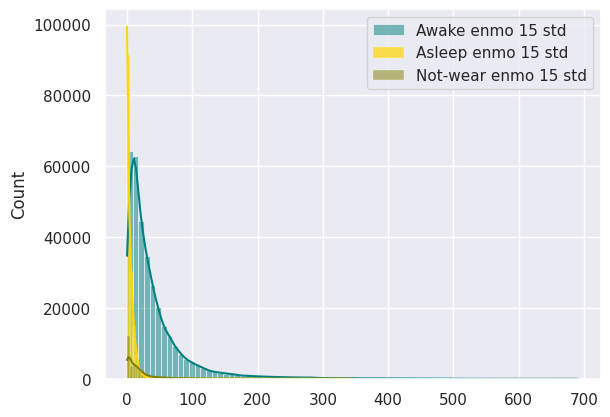

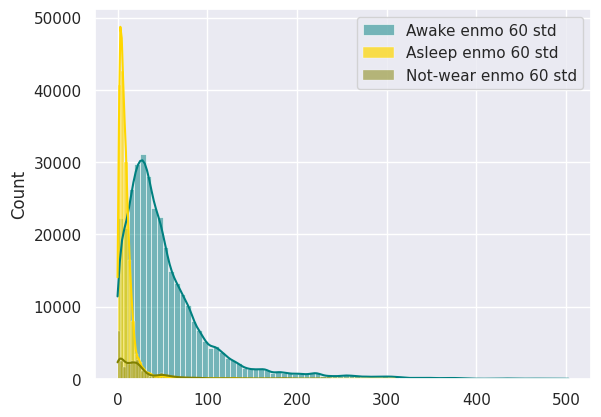

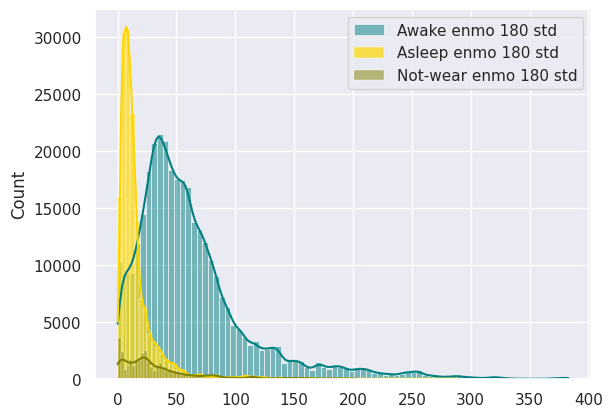

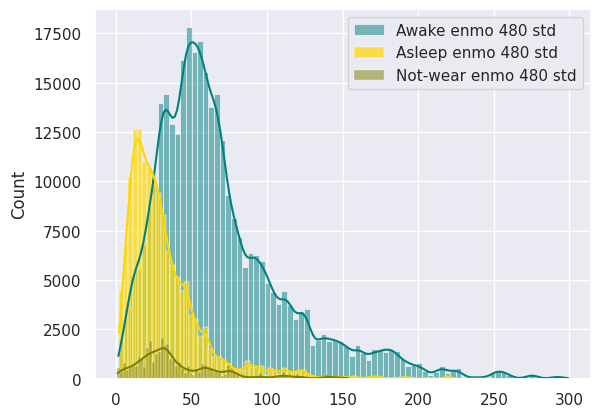

In [49]:
vars = ["enmo"]*4
times = [15, 60, 60*3, 60*8]
stats = ["std"]*4
for var, time, stat in zip(vars, times, stats):
    plot_histogram(var, time, stat)

Summary
- With standard deviation of "enmo" feature we can distinct awake from other states.

## Time plots

In [140]:
def plot_data(df, idx):
    print(idx)
    df=df.to_pandas()
    df = df.loc[df['series_id']==idx].sort_values(by='dt_minute')

    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    # Plotting time series data
    fig.add_trace(go.Scatter(x=df['dt_minute'], y=df['anglez'], mode='lines', name='anglez'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df['dt_minute'], y=df['enmo'], mode='lines', name='enmo'), secondary_y=True)
    
    # Plotting sleeping periods
    onsets = df.loc[(df[labels].diff()!=0)&(df[labels]==1)]['dt_minute'].to_list()
    wakeups = df.loc[(df[labels].diff()==-1)&(df[labels]==0)|(df[labels].diff()==1)&(df[labels]==2)]['dt_minute'].to_list()
    for onset, wakeup in zip(onsets, wakeups) :
        fig.add_vrect(
            x0=onset, x1=wakeup,
            fillcolor='gray', opacity=0.2,
            layer='below', line_width=0
        )
        
    # Add dummy trace for the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='gray', width=0),
        fill='tozeroy',
        fillcolor='gray',
        opacity=0.2,
        name="Sleeping periods"
        ))
    
    # Plotting notwear periods
    onsets = df.loc[(df[labels].diff()>0)&(df[labels]==2)]['dt_minute'].to_list()
    wakeups = df.loc[(df[labels].diff()<0)&(df[labels]!=2)]['dt_minute'].to_list()

    # if all time not-wear
    stats = df.groupby("target").dt_minute.count()
    not_wear_num = stats.loc[stats.index==2]
    if not not_wear_num.empty and df.shape[0] == not_wear_num.tolist()[0]:
        onsets = [df["dt_minute"].min()]
        wakeups = [df["dt_minute"].max()]
        
    if len(wakeups) < len(onsets):
        wakeups = wakeups + [df["dt_minute"].max()]
    for onset, wakeup in zip(onsets, wakeups) :
        fig.add_vrect(
            x0=onset, x1=wakeup,
            fillcolor='violet', opacity=0.2,
            layer='below', line_width=0
        )
        
    # Add dummy trace for the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='violet', width=0),
        fill='tozeroy',
        fillcolor='violet',
        opacity=0.7,
        name="Not-wear periods"
        ))

    fig.update_layout(
        title_text=f"Accelerometer Data - Full Minutes Averages<br><sub>series_id: {idx}</sub>", 
        #template = 'ggplot2',
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), yaxis2=dict(showgrid=False)
        )
    
    fig.show()

In [142]:
# df.filter((pl.col("series_id")==df["series_id"].unique().sort().to_numpy()[15])&(pl.col("step")>12*60*24)).head(25)

In [183]:
df.filter((pl.col("series_id")==df["series_id"].unique().sort().to_numpy()[37])).group_by("target").agg(pl.col("dt_minute").count())

target,dt_minute
i64,u32
0,3141
1,1180


In [186]:
df.group_by(["series_id","target"]).agg(pl.col("dt_minute").count()).filter(pl.col("target")==2)

series_id,target,dt_minute
str,i64,u32
"""0f9e60a8e56d""",2,4321
"""df33ae359fb5""",2,4321
"""c7d693f24684""",2,4321
"""2fc653ca75c7""",2,4321
"""dff367373725""",2,4321
"""90eac42a9ec9""",2,4321
"""a3e59c2ce3f6""",2,4321
"""1f96b9668bdf""",2,4321


05e1944c3818


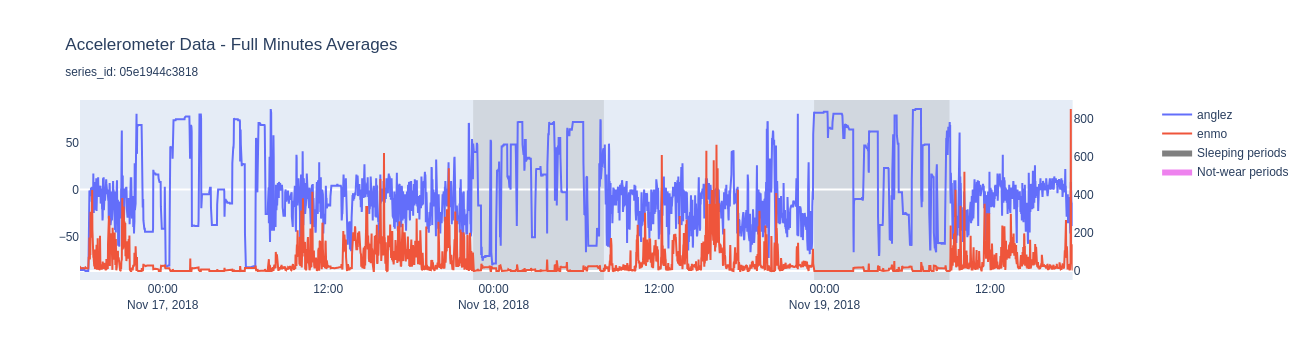

In [144]:
%timeit
plot_data(df, idx=df["series_id"].unique().sort().to_numpy()[0])

In [ ]:
"0cfc06c129cc",
"0ec9fc461819",
"0ef7d94fde99",
"0f9e60a8e56d",# all nulls - correct
"1087d7b0ff2e",
"12d01911d509",
"1319a1935f48",
"1716cd4163b2",
"18a0ca03431d",
"1955d568d987",
"1f96b9668bdf", # all nulls - correct
"29c75c018220",
"2e9ced2c7976",
"2fbbee1a38e3",
"349c5562ee2c",
"3c336d6ba566",
"3d53bfea61d6",
"3df0da2e5966",
"405df1b41f9f",
"519ae2d858b0",
"51b23d177971",
"559ffb7c166a",
"55a47ff9dc8a",


1955d568d987


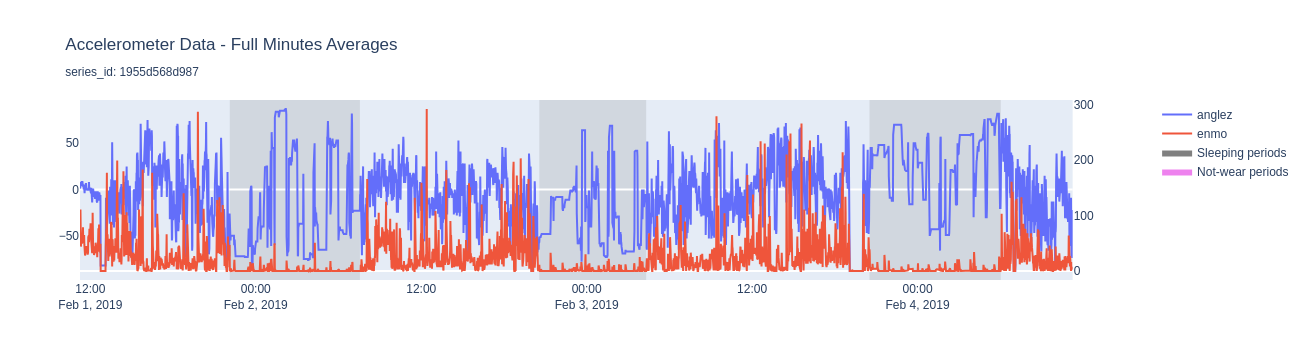

In [189]:
%timeit
plot_data(df, idx="1955d568d987")